# Run "Classic" pandas version of processing with MCMC Bayesian method

In [1]:
import pandas as pd
#import MarineDNA as md
import plotly.express as px
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import itertools

%load_ext autoreload
%autoreload 2

## Import the data

In [2]:
file1 = "../Data/merged_data/no_duplicates/Merged2018_16S_otu_filtered.csv"
file2 = "../Data/merged_data/no_duplicates/Merged2018_18S_otu_filtered.csv"
asvs_16S = pd.read_csv(file1, index_col=0)
asvs_18S = pd.read_csv(file2, index_col=0)


In [3]:
# get lists of sample and asv names
labels_samples_16S = list(asvs_16S)
labels_samples_18S = list(asvs_18S)
labels_asvs_16S = asvs_16S.index.tolist()
labels_asvs_18S = asvs_18S.index.tolist()

print('Number of 16S ASVs:', len(labels_asvs_16S))
print('Number of 16S samples:', len(labels_samples_16S))
print('Number of 18S ASVs:', len(labels_asvs_18S))
print('Number of 18S samples:', len(labels_samples_18S))

Number of 16S ASVs: 7077
Number of 16S samples: 131
Number of 18S ASVs: 10475
Number of 18S samples: 131


## Functions

In [4]:
# Return data frame of a draw of relative percent of occurrence from a beta distribution
# fit to observed occurrence counts
#   df: data frame where rows = ASVs and columns = samples
def ranRelPct(df, asLogOdds = True):
    import pandas as pd
    import numpy as np
    
    def betaCol(col):
        beta_dist = np.random.beta(col + 1, col.sum() - col + 1)
        return beta_dist / beta_dist.sum()
    result = np.empty([df.shape[0], df.shape[1]])
    for i in range(result.shape[1]):
        result[:,i] = betaCol(df.iloc[:,i])
    if asLogOdds:
        result = np.log(result / (1 - result))
    return pd.DataFrame(result, index = df.index, columns = df.columns).transpose()

In [5]:
# Does hierarchical clustering on data frame where rows are samples and columns are ASVs
# Returns array of cluster labels for rows
def doClustering(df, num_clusts, num_pcs = None):
    from sklearn.cluster import AgglomerativeClustering
    
    agg_clust = AgglomerativeClustering(n_clusters = num_clusts, metric = "euclidean", linkage = "ward")
    labels = agg_clust.fit_predict(df)
    return labels.astype(str)

In [6]:
def pctSame(df, n_clust, n_rep):
    if n_clust >= df.shape[0]:
        return 100
    
    def isSameCluster(pws, df, col):
        return df.iloc[pws[0], col] == df.iloc[pws[1], col]
    
    def maxSame(row):
        unique, counts = np.unique(row, return_counts=True)
        return max(counts)
    
    # cluster a random sample of logit(relative percentages)
    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]
    cluster_samples = pd.DataFrame(cluster_samples).transpose()
    # unique pairs of rows
    *pws_rows, = itertools.combinations(range(cluster_samples.shape[0]), 2)
    pws_same = np.empty([len(pws_rows), n_rep])
    for c in range(pws_same.shape[1]):
        for r in range(pws_same.shape[0]):
            pws_same[r, c] = cluster_samples.iloc[pws_rows[r][0], c] == cluster_samples.iloc[pws_rows[r][1], c]
    
    # get the maximum number replicates that have the same value (True or False) for each sample
    num_same = [maxSame(pws_same[row, :]) for row in range(pws_same.shape[0])]
    # convert to percentage with maximum of same value across all replicates
    return np.sum(num_same) * 100 / (pws_same.shape[0] * pws_same.shape[1])

In [7]:
# Does PCA
#   df: data frame where rows = samples and columns = ASVs
#   num_pcs: number of components to return. if None, return maximum number
# Returns a dictionary containing :
#   scores: array of PCA scores
#   loadings: array of PCA loadings
def doPCA(df, num_pcs = None):
    import numpy as np
    from sklearn.decomposition import PCA
    
    max_pcs = min(df.shape[0] - 1, df.shape[1] - 1)
    if num_pcs is None:
        num_pcs = max_pcs
    elif num_pcs > max_pcs:
        num_pcs = max_pcs
    pca = PCA(n_components = num_pcs)
    pca_fit = pca.fit(df)
    pca_results = {
        "scores": pca_fit.transform(df),
        "loadings": np.transpose(pca_fit.components_),
        "explained_variance": pca.explained_variance_ratio_
        # add line exported explained variance
    }
    return pca_results

## One draw

In [8]:
# one random draw
ran_lo_16S = ranRelPct(asvs_16S)
ran_lo_18S = ranRelPct(asvs_18S)
# one PCA
pca_results_16S = doPCA(ran_lo_16S,num_pcs =6)
pca_results_18S = doPCA(ran_lo_18S,num_pcs =6)

In [9]:
# Format PCA results:
#16S
df = pd.DataFrame(pca_results_16S["scores"], index=labels_samples_16S)
df.columns = '16S_PC'+(df.columns + 1).astype(str)
pca_scores_16S = df.copy()

#18S
df = pd.DataFrame(pca_results_18S["scores"], index=labels_samples_18S)
df.columns = '18S_PC'+(df.columns + 1).astype(str)
pca_scores_18S = df.copy()
df.head()

,18S_PC1,18S_PC2,18S_PC3,18S_PC4,18S_PC5,18S_PC6
CN18FESPkoa_SC24,-28.533910,57.518267,-25.669812,-0.036502,-2.965365,-13.325031
CN18Fc21_6_eDNA,34.456886,53.073068,-22.964038,-3.025442,1.479386,11.478811
CN18Fc22_6_eDNA,30.467342,55.725030,-23.201850,-6.011443,1.820067,13.594266
CN18Fc24_6_eDNA,6.896811,57.324532,-25.301187,2.936295,1.647538,2.515659
CN18Fc25_5_eDNA,22.358736,34.229903,-9.952900,1.773984,-2.944202,5.724642


In [10]:
# Make dataframe of first 6 16S PC scores and first 2 18S PC scores
df = pd.concat([pca_scores_16S.iloc[:,:7], pca_scores_18S.iloc[:,:2]], axis=1)
comb_scores = df.copy()
comb_scores.head()

,16S_PC1,16S_PC2,16S_PC3,16S_PC4,16S_PC5,16S_PC6,18S_PC1,18S_PC2
CN18Fc43_5_eDNA,-56.175596,-0.751978,17.606939,-2.063926,2.383148,-3.783902,45.525196,53.594873
CN18FESPkoa_SC58,-55.265259,-5.270801,13.100629,-7.089890,-0.450442,-4.368396,43.816693,50.478775
CN18FESPkoa_SC43,-58.242105,-2.163226,11.281121,-5.069624,1.815458,-5.477454,17.842591,63.650859
CN18FESPkoa_SC40,-64.240810,0.477899,3.673747,-3.749291,1.073001,-0.819445,-11.606641,60.925243
CN18FESPkoa_SC37,-12.478316,-17.336980,45.863615,2.211835,-1.834065,0.705190,-2.166167,66.073639


In [19]:
dataset_HA2 =comb_scores.copy()
dataset_HA2 = dataset_HA2.iloc[:,:-1]
dataset_HA2

,16S_PC1,16S_PC2,16S_PC3,16S_PC4,16S_PC5,16S_PC6,18S_PC1
CN18Fc43_5_eDNA,-56.175596,-0.751978,17.606939,-2.063926,2.383148,-3.783902,45.525196
CN18FESPkoa_SC58,-55.265259,-5.270801,13.100629,-7.089890,-0.450442,-4.368396,43.816693
CN18FESPkoa_SC43,-58.242105,-2.163226,11.281121,-5.069624,1.815458,-5.477454,17.842591
CN18FESPkoa_SC40,-64.240810,0.477899,3.673747,-3.749291,1.073001,-0.819445,-11.606641
CN18FESPkoa_SC37,-12.478316,-17.336980,45.863615,2.211835,-1.834065,0.705190,-2.166167
...,...,...,...,...,...,...,...
Lasker18Sc145_19,16.223913,-30.866386,-37.648991,15.395976,-16.344352,-16.430875,-105.651409
Lasker18Sc145_3,24.876039,23.075042,0.471000,-21.384022,-10.724172,7.771335,17.224216
Lasker18Sc145_5,32.855017,16.873158,12.228704,-20.658673,-7.499572,8.269615,-1.138751
Lasker18Sc150_17,-0.021808,-21.372811,-50.008176,-0.361079,-9.806558,-13.046005,-95.765339


# HMC - MCMC - NUTS

In [28]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible,
)
from pyro.infer.reparam import AutoReparam, LocScaleReparam
from pyro.nn.module import PyroParam
from pyro.optim import ClippedAdam
from pyro.ops.special import sparse_multinomial_likelihood
import matplotlib.pyplot as plt

In [24]:
import torch
import pyro

In [25]:
def model(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_PC1 = pyro.sample("b1", dist.Normal(0., 1.))
    b_PC2 = pyro.sample("b2", dist.Normal(0., 1.))
    b_PC3 = pyro.sample("b3", dist.Normal(0., 1.))
    b_PC4 = pyro.sample("b4", dist.Normal(0., 1.))
    b_PC5 = pyro.sample("b5", dist.Normal(0., 1.))
    b_PC6 = pyro.sample("b6", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 100.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with pyro.plate("data", len(pc6_values_16)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=pc1_values_18)

In [26]:
train = torch.tensor(dataset_HA2.values, dtype=torch.float)
pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18 = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6]


In [29]:
%%time
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=4000, warmup_steps=1000#, mp_context= 'spawn' 
           ) # use mp_context=”spawn” for cuda #time = 5000
mcmc.run(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 5000/5000 [00:56, 88.81it/s, step size=7.82e-01, acc. prob=0.866] 

CPU times: user 56.3 s, sys: 89.9 ms, total: 56.3 s
Wall time: 56.3 s


In [30]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0 -0.013987  2.073271 -3.483677 -1.397241 -0.014658  1.341499  3.462308 

Site: b1
       mean       std        5%       25%       50%       75%       95%
0 -0.331415  0.059545 -0.429443 -0.371611 -0.330482 -0.290934 -0.236171 

Site: b2
       mean      std        5%      25%       50%       75%       95%
0  1.396166  0.07417  1.273197  1.34661  1.397825  1.446061  1.518299 

Site: b3
       mean       std        5%       25%       50%       75%       95%
0  0.962215  0.077708  0.832393  0.911681  0.961946  1.013267  1.089336 

Site: b4
       mean       std        5%       25%      50%       75%       95%
0  0.550515  0.111204  0.368944  0.473625  0.55068  0.624864  0.734494 

Site: b5
       mean       std        5%       25%       50%       75%       95%
0 -0.327306  0.132896 -0.541822 -0.416749 -0.326486 -0.238929 -0.107588 

Site: b6
       mean       std        5%       25%       50%       75%       

In [32]:
import seaborn as sns

/tmp/ipykernel_638/841611288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_samples[site], ax=ax, label="HMC1")
/tmp/ipykernel_638/841611288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hmc_samples[site], ax=ax, label="HMC1")
/tmp/ipykernel_638/841611288.py:7: UserWarning: 

`dis

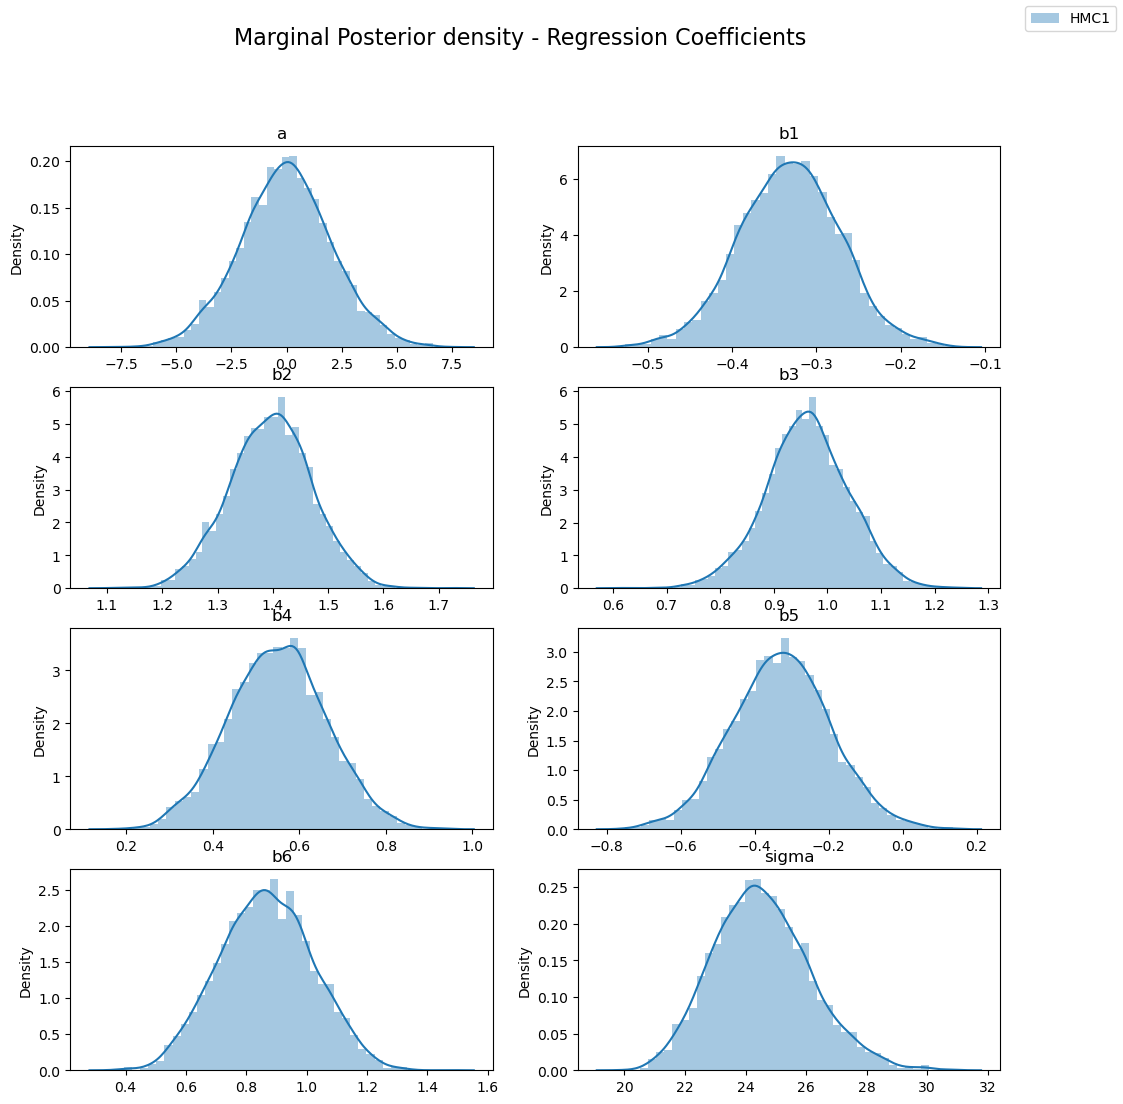

In [33]:
sites = ["a", "b1", "b2", "b3", "b4", "b5", "b6","sigma"]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(hmc_samples[site], ax=ax, label="HMC1")
    #sns.distplot(hmc_samples[site], ax=ax, label="HMC2")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [34]:
df = pd.DataFrame(hmc_samples)
df = df.T
df['mean'] = df.mean(axis=1)
df['abs'] = df['mean'].abs()
df = df.sort_values('abs', ascending=False)
df= df[['mean', 'abs']]
#for i in list(df):
#    print(i)
#    print(df[i].mean())
df

,mean,abs
sigma,24.542101,24.542101
b2,1.396166,1.396166
b3,0.962215,0.962215
b6,0.866417,0.866417
b4,0.550515,0.550515
b1,-0.331415,0.331415
b5,-0.327306,0.327306
a,-0.013987,0.013987
